In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import datetime as dt
import re
from wordcloud import WordCloud
from textblob import TextBlob
import ast


# Movie Dataset Analysis Pipeline
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.cluster import KMeans

In [2]:
fusion = pd.read_csv('/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv')


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,fr_entries,fr_entries_cumul,fr_entry_week,us_entries,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes,producers_list,producers_count,top_stars_list,top_stars_count,languages_list,languages_count,nationality_list,nationality_list_count,associated_genres_allocine_list,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,release_date_us
0,20941,"Abigail, le pouvoir de l'Elue",https://www.jpbox-office.com/cinema/images/pos...,2019,08-01-2020,00-00-0000,"U.S.A.,Russie",Anglais,1h 51min,NaN,Aleksandr Boguslavskiy,"Tinatin Dalakishvili,Eddie Marsan,Rinal Mukham...","Aleksandr Boguslavskiy,Dmitriy Zhigalov",Fantasy,"Action,Fantastique","Un siècle après le début de la Contamination, ...",-,NaN,en VOD,Condor Distribution,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,1835634.0,1.9,1.9,"241 notes, 40 critiques","241 notes, 40 critiques","47 731,vues",Winter,111.0,"['Aleksandr Boguslavskiy', 'Dmitriy Zhigalov']",2,"['Tinatin Dalakishvili', 'Eddie Marsan', 'Rina...",3,['Anglais'],1,"['U.S.A.', 'Russie']",2,"['Action', 'Fantastique']",2,0,0,0,0,0,241,0,0,0,241,40,47731.0,546,NaN
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010,10-02-2010,12-02-2010,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150000000.0,214 497,334 885,10-02-2010 – 17-02-2010,30 627 000,12-02-2010 – 15-02-2010,61937495.0,77810085.0,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0,"['Joe Johnston', 'Andrew Kevin Walker', 'David...",3,"['Benicio Del Toro', 'Anthony Hopkins', 'Emily...",3,"['Anglais', 'Roumain']",2,[],0,"['Fantastique', 'Epouvante-horreur', 'Thriller']",3,6,6,9,214497,30627000,14,1,2,3,4274,791,NaN,245,NaN
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019,01-01-2020,15-11-2019,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10000000.0,66 229,105 205,01-01-2020 – 08-01-2020,5 605 051,15-11-2019 – 18-11-2019,17156058.0,11200000.0,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0,"['Bill Condon', 'Jeffrey Hatcher']",2,"['Helen Mirren', 'Ian McKellen', 'Russell Tovey']",3,['Anglais'],1,"['U.S.A.', 'Canada']",2,"['Drame', 'Thriller']",2,1,46,2,66229,5605051,16,0,0,0,1847,186,NaN,620,NaN
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008,06-01-2010,00-00-0000,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06-01-2010 – 13-01-2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0,['Ounie Lecomte'],1,"['Kim Sae-Ron', 'Park Doyeon', 'Park Myeong-Sh...",3,['Coréen'],1,"['France', 'Corée du Sud']",2,['Drame'],1,1,0,1,16820,0,19,1,1,2,274,56,NaN,431,NaN
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008,14-04-2010,1

In [ ]:
# Remove row with missing FR entries
df_fusion = fusion[fusion['opening_week_france_num'] != 0]

In [ ]:
# sns.displot(df_fusion['opening_week_france_num'], kde=True, rug=True)
# plt.title('Distribution of FR Entries')
# plt.xlabel('Number of Entries')
# plt.show()

#### 1. Descriptive Analysis

#### 2. Mulit-variate Analysis

In [ ]:
def multi_stats(df):  # sourcery skip: extract-method, merge-comparisons
    # Top Genres
    top_genres = df['main_genre_jpboxoffice'].value_counts().head(10).reset_index()
    top_genres.columns = ['Genre', 'Count']
    
    # Top actors
    if 'top_stars_list' in df.columns:
        actors_series = df['top_stars_list'].dropna()
        exploded_actors = actors_series.explode()
        top_actors = exploded_actors.value_counts().head(10).to_frame(name='Appearances')
        top_actors.index.name = 'Actor'
        top_actors.reset_index(inplace=True)
        # Remove rows where Actor is an empty list or empty string
        top_actors = top_actors[top_actors['Actor'].apply(lambda x: x != "[]" and x != '')]
    else:
        top_actors = pd.DataFrame(columns=['Actor', 'Appearances'])

    # Average Movie Duration Per Year
    avg_movie_dur = (
        df.groupby('year_of_production')['duration_minutes']
        .mean()
        .reset_index()
        .sort_values(by='year_of_production')
    )
    avg_movie_dur.columns = ['Year', 'Average_Duration_Minutes']

    return top_genres, top_actors, avg_movie_dur

In [ ]:
top_genres, top_actors, avg_movie_dur = multi_stats(df_fusion)

In [ ]:
def plot_distribution(top_genres, top_actors, avg_movie_dur):
    # Top Genres
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')
    plt.title('Top Genres')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

    # Top Actors
    if not top_actors.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma')
        plt.title('Top Actors by Number of Appearances')
        plt.xlabel('Number of Appearances')
        plt.ylabel('Actor')
        plt.tight_layout()
        plt.show()
    else:
        print("No actor data to display.")

    # Average Movie Duration per Year
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_movie_dur, x='Year', y='Average_Duration_Minutes', marker='o', color='orange')
    plt.title('Average Movie Duration Per Year')
    plt.xlabel('Year')
    plt.ylabel('Duration (minutes)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_52745/3817607576.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')


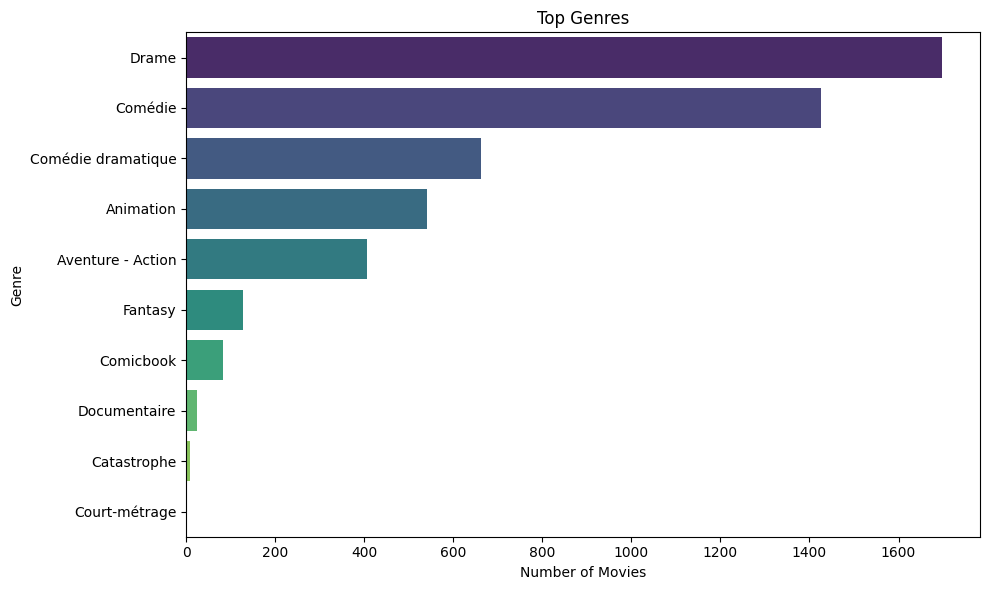

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_52745/3817607576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma')


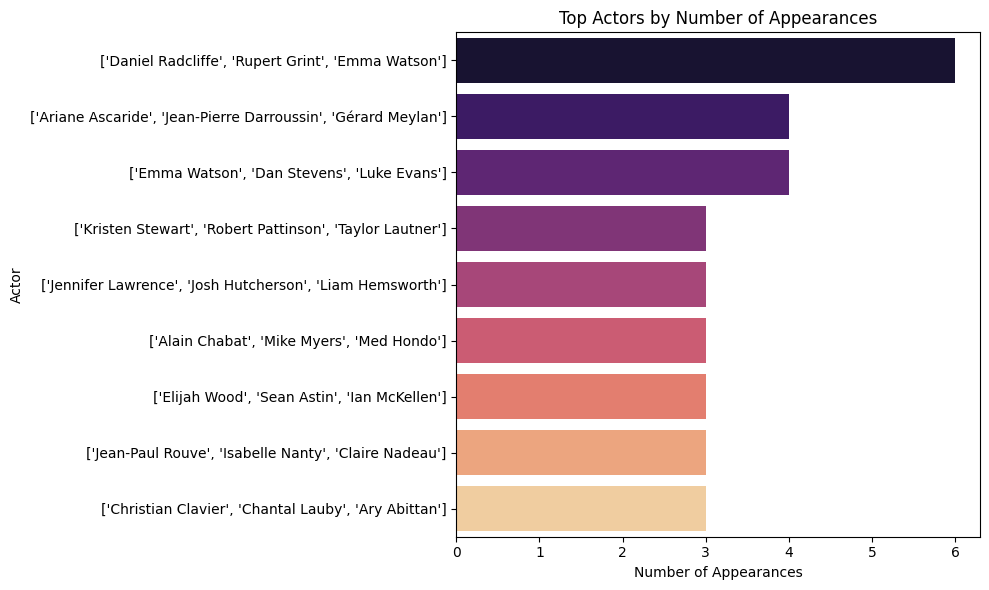

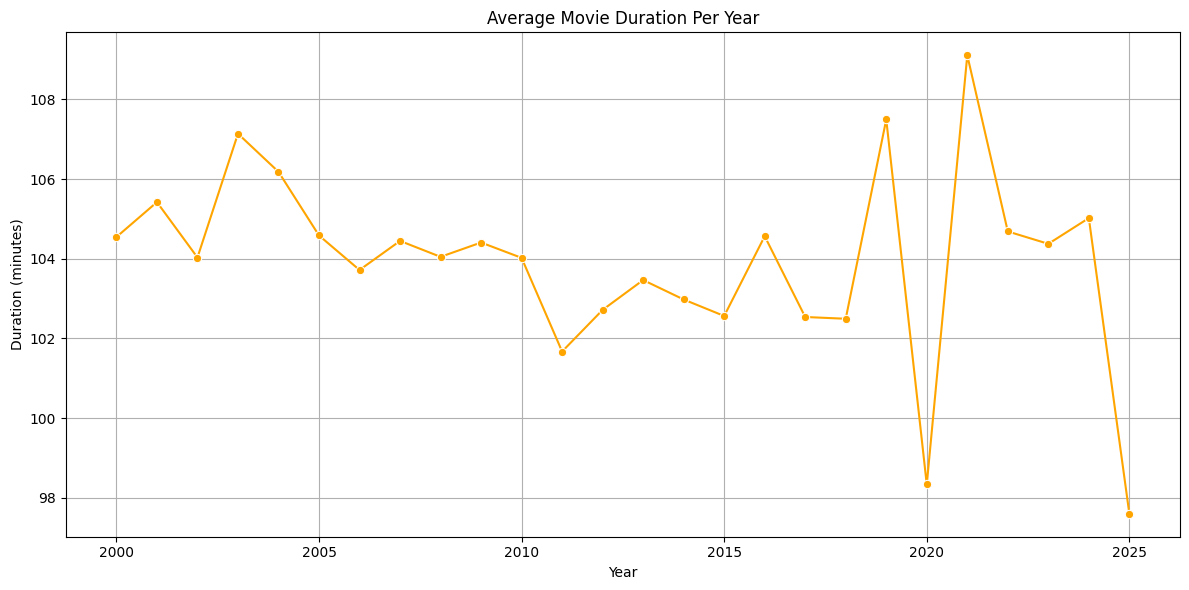

In [13]:
plot_distribution(top_genres, top_actors, avg_movie_dur)

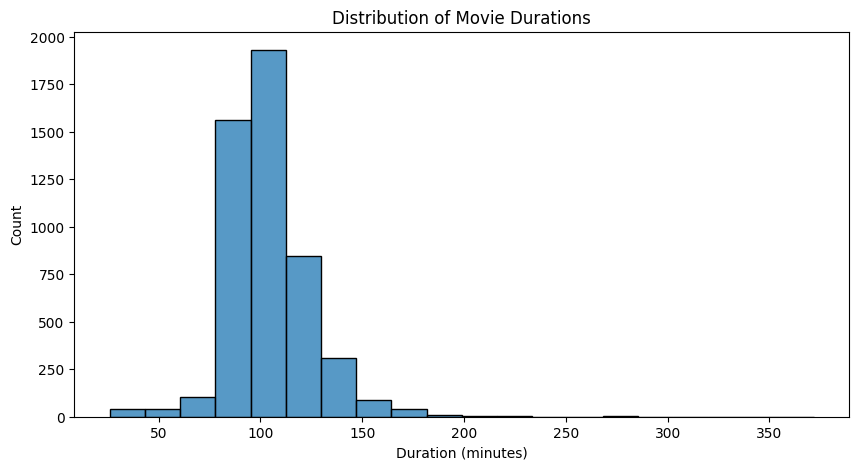

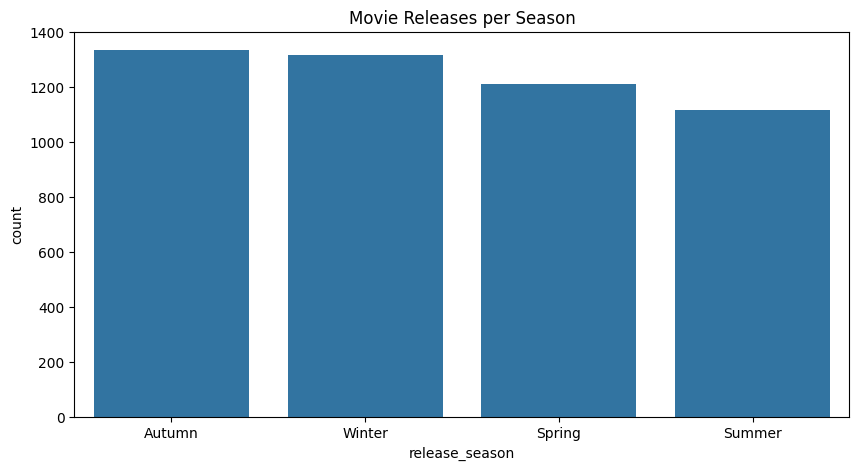

In [14]:
def plot_distribution(df):
    plt.figure(figsize=(10,5))
    sns.histplot(df['duration_minutes'].dropna(), bins=20)
    plt.title('Distribution of Movie Durations')
    plt.xlabel('Duration (minutes)')
    plt.show()

    plt.figure(figsize=(10,5))
    sns.countplot(x='release_season', data=df, order=df['release_season'].value_counts().index)
    plt.title('Movie Releases per Season')
    plt.show()

plot_distribution(df_fusion)

#### 2. Performance Analysis (Bivariate and Multi-variate Analysis)

In [16]:
def genre_performance(df):
    genre_perf = (
        df.groupby('main_genre_jpboxoffice')[['opening_week_france_num', 'viewer_rating']]
        .mean()
        .sort_values(by='opening_week_france_num', ascending=False)
        .reset_index()
    )
    return genre_perf

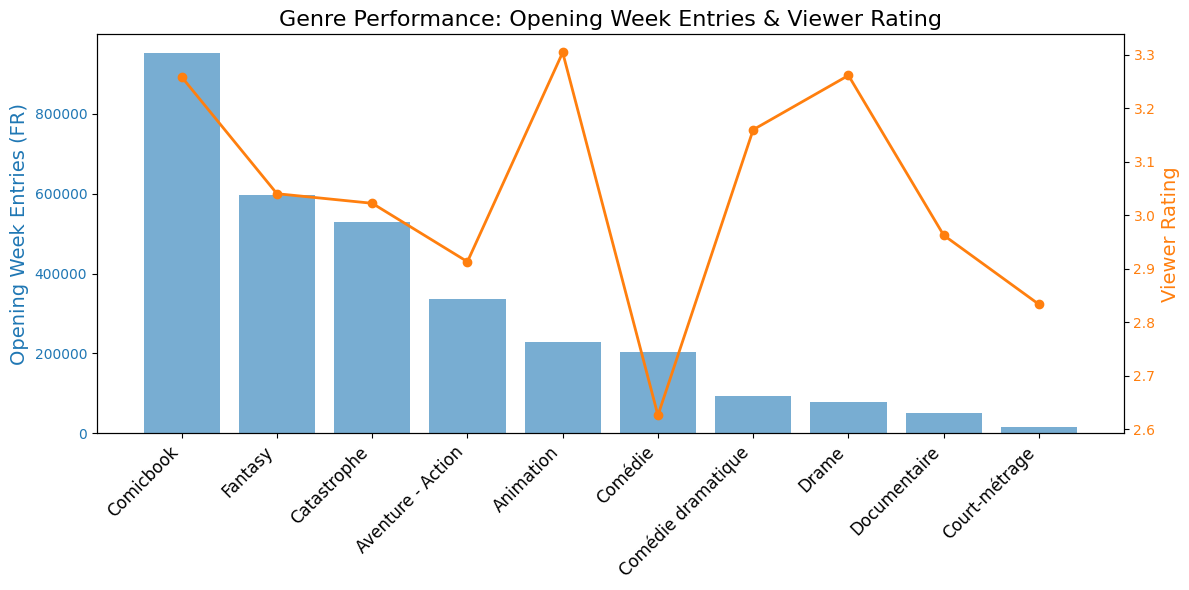

In [17]:
def plot_genre_performance_dual_axis(genre_perf_df):
    df_sorted = genre_perf_df.sort_values(by='opening_week_france_num', ascending=False)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    genres = df_sorted['main_genre_jpboxoffice']
    x = np.arange(len(genres))

    color1 = 'tab:blue'
    ax1.bar(x, df_sorted['opening_week_france_num'], color=color1, alpha=0.6, label='Opening Week Entries')
    ax1.set_ylabel('Opening Week Entries (FR)', color=color1, fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(genres, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(x, df_sorted['viewer_rating'], color=color2, marker='o', linewidth=2, label='Viewer Rating')
    ax2.set_ylabel('Viewer Rating', color=color2, fontsize=14)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title('Genre Performance: Opening Week Entries & Viewer Rating', fontsize=16)
    fig.tight_layout()
    plt.show()


genre_perf_df = genre_performance(df_fusion)
plot_genre_performance_dual_axis(genre_perf_df)

In [ ]:
def actor_success_1(df):
    exploded = df[['top_stars_list', 'revenue_world']].explode('top_stars_list')
    actor_rev = exploded.groupby('top_stars_list')['revenue_world'].mean().sort_values(ascending=False)
    
    print("\n--- Top Revenue-Generating Actors ---")
    actors_suc = actor_rev.head(10).reset_index()
    actors_suc.columns = ['Actor', 'Average_Revenue_World']
    
    return actors_suc


--- Top Revenue-Generating Actors ---
                                               Actor  Average_Revenue_World
0  ['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...           1.939428e+09
1  ['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...           1.369896e+09
2     ['Vin Diesel', 'Paul Walker', 'Jason Statham']           1.163039e+09
3     ['Daisy Ridley', 'John Boyega', 'Adam Driver']           1.131561e+09
4  ['Rayane Bensetti', 'Donald Glover', 'Anne Sila']           1.113305e+09
5  ['Charlotte Le Bon', 'Amy Poehler', 'Jaynelia ...           1.023200e+09
6  ['Chris Pratt', 'Bryce Dallas Howard', 'Nick R...           1.019443e+09
7  ['Vin Diesel', 'Dwayne Johnson', 'Jason Statham']           1.009997e+09
8  ['Chris Pratt', 'Bryce Dallas Howard', 'Rafe S...           8.917647e+08
9    ['Emmylou Homs', 'Kristen Bell', 'Anaïs Delva']           8.757423e+08


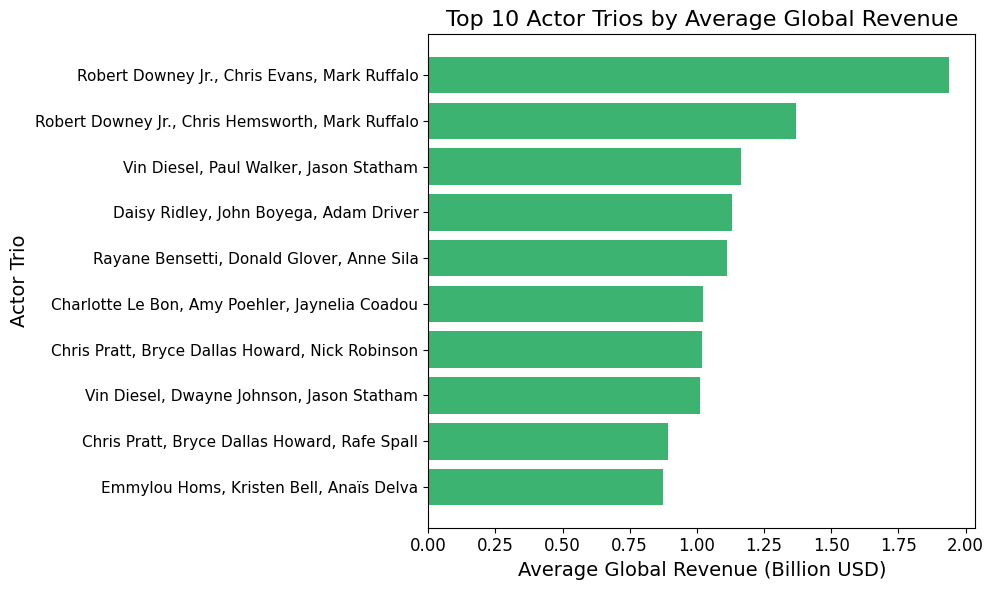

In [14]:
def plot_actor_trio_success(actor_rev_df):
    # Convert stringified lists to actual lists
    actor_rev_df['Actor_Label'] = actor_rev_df['Actor'].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
    )

    # Convert revenue to billions
    actor_rev_df['Revenue_Billion'] = actor_rev_df['Average_Revenue_World'] / 1e9

    # Sort by revenue for barh plot
    plot_df = actor_rev_df.sort_values(by='Revenue_Billion', ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        plot_df['Actor_Label'],
        plot_df['Revenue_Billion'],
        color='mediumseagreen'
    )
    plt.title('Top 10 Actor Trios by Average Global Revenue', fontsize=16)
    plt.xlabel('Average Global Revenue (Billion USD)', fontsize=14)
    plt.ylabel('Actor Trio', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


actor_rev_df = actor_success_1(df_fusion)
print(actor_rev_df)
plot_actor_trio_success(actor_rev_df)


In [18]:
df_fusion.columns

Index(['film_id', 'film_title', 'image_url', 'year_of_production',
       'release_date_france', 'release_date_usa', 'nationality', 'languages',
       'duration', 'age_classification', 'director', 'top_stars', 'producers',
       'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
       'filming_secrets', 'awards', 'broadcast_category', 'distributor',
       'budget', 'fr_entries', 'fr_entries_cumul', 'fr_entry_week',
       'us_entries', 'us_entry_week', 'revenue_usa', 'revenue_world',
       'press_rating', 'viewer_rating', 'press_critics_count',
       'viewer_critics_count', 'trailer_views', 'release_season',
       'duration_minutes', 'producers_list', 'producers_count',
       'top_stars_list', 'top_stars_count', 'languages_list',
       'languages_count', 'nationality_list', 'nationality_list_count',
       'associated_genres_allocine_list', 'associated_genres_allocine_count',
       'fr_entry_week_iso_week', 'us_entry_week_iso_week',
       'filming_secrets_nu

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_57964/3682871987.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')


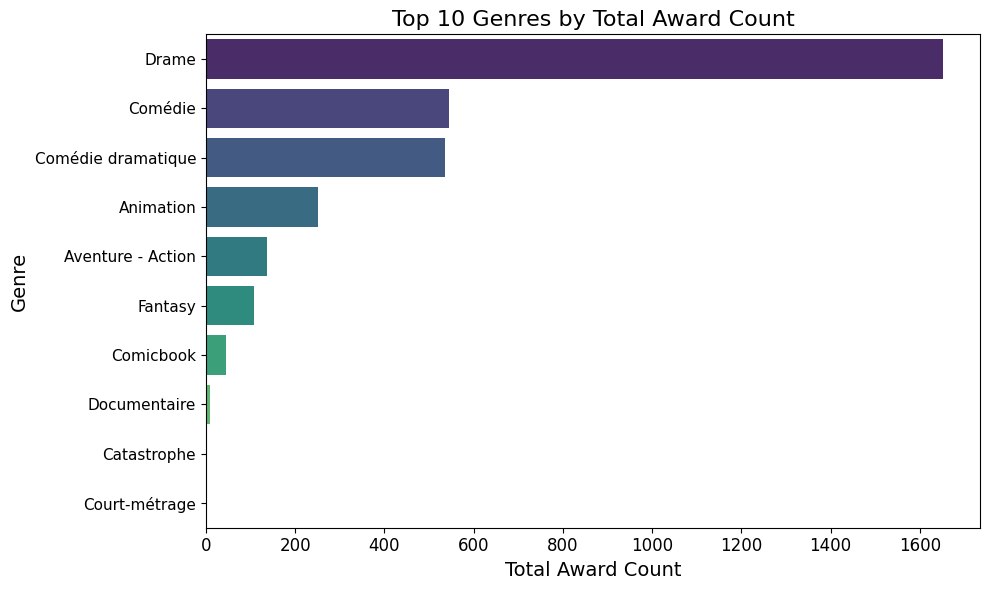

In [19]:
def plot_genre_awards(df):
    # Handle multiple genres per movie
    exploded = df[['main_genre_jpboxoffice', 'award_count']].copy()
    exploded['main_genre_jpboxoffice'] = exploded['main_genre_jpboxoffice'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
    exploded = exploded.explode('main_genre_jpboxoffice')

    # Group by genre and sum awards
    genre_awards = exploded.groupby('main_genre_jpboxoffice')['award_count'].sum().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')
    plt.title('Top 10 Genres by Total Award Count', fontsize=16)
    plt.xlabel('Total Award Count', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_genre_awards(df_fusion)

In [21]:
df_fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,fr_entries,fr_entries_cumul,fr_entry_week,us_entries,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes,producers_list,producers_count,top_stars_list,top_stars_count,languages_list,languages_count,nationality_list,nationality_list_count,associated_genres_allocine_list,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,release_date_us
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010,10-02-2010,12-02-2010,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150000000.0,214 497,334 885,10-02-2010 – 17-02-2010,30 627 000,12-02-2010 – 15-02-2010,61937495.0,77810085.0,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0,"['Joe Johnston', 'Andrew Kevin Walker', 'David...",3,"['Benicio Del Toro', 'Anthony Hopkins', 'Emily...",3,"['Anglais', 'Roumain']",2,[],0,"['Fantastique', 'Epouvante-horreur', 'Thriller']",3,6,6,9,214497,30627000,14,1,2,3,4274,791,NaN,245,NaN
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019,01-01-2020,15-11-2019,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10000000.0,66 229,105 205,01-01-2020 – 08-01-2020,5 605 051,15-11-2019 – 18-11-2019,17156058.0,11200000.0,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0,"['Bill Condon', 'Jeffrey Hatcher']",2,"['Helen Mirren', 'Ian McKellen', 'Russell Tovey']",3,['Anglais'],1,"['U.S.A.', 'Canada']",2,"['Drame', 'Thriller']",2,1,46,2,66229,5605051,16,0,0,0,1847,186,NaN,620,NaN
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008,06-01-2010,00-00-0000,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06-01-2010 – 13-01-2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0,['Ounie Lecomte'],1,"['Kim Sae-Ron', 'Park Doyeon', 'Park Myeong-Sh...",3,['Coréen'],1,"['France', 'Corée du Sud']",2,['Drame'],1,1,0,1,16820,0,19,1,1,2,274,56,NaN,431,NaN
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008,14-04-2010,16-10-2009,NaN,Anglais,1h 43min,NaN,Mira Nair,"Hayden Christensen,Rachel Bilson,Andy Garcia","Mira Nair,Fatih Akın,Yvan Attal",Court-métrage,Comédie dramatique,"Depuis l'invention du cinéma, New York n'a jam...",15 anecdotes,NaN,en salle,Metropolitan FilmExport,14700000.0,39 797,103 782,14-04-2010 – 21-04-2010,NaN,NaN,1585787.0,6427072.0,2.8,2.7,16 critiques,"1472 notes, 166 critiques",NaN,Spring,103.0,"['Mira Nair', 'Fatih Akın', 'Yvan Attal']",3,"['Hayden Christensen', 'Rachel Bilson', 'Andy ...",3,['Anglais'],1,[],0,['Comédie dramatique'],1,15,0,15,39797,0,16,0,0,0,1472,166,NaN,353,NaN
5,2225,Pas d'histoires ! 12 regards sur le racisme au...,https://www.jpbox-office.com/cinema/images/pos...,2001,17-01-2001,00-00-0000,NaN,-

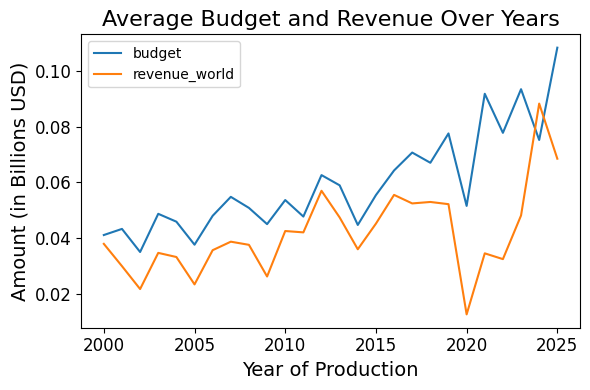

In [ ]:
# # Time-Series Analysis

def trend_budget_revenue(df):
    # Group by year and calculate mean
    yearly = df.groupby('year_of_production')[['budget', 'revenue_world']].mean()

    # Convert to billions
    yearly_billion = yearly / 1e9

    # Plot
    plt.figure(figsize=(6, 4))
    yearly_billion.plot(ax=plt.gca())
    plt.title("Average Budget and Revenue Over Years", fontsize=16)
    plt.ylabel('Amount (in Billions USD)', fontsize=14)
    plt.xlabel('Year of Production', fontsize=14)
    # plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

trend_budget_revenue(df_fusion)

Lawrence Talbot est un aristocrate torturé que la disparition de son frère force à revenir au domaine familial. Contraint de se rapprocher à nouveau de son père, Talbot se lance à la recherche de son frère...et se découvre une terrible destinée. Escroc professionnel, Roy Courtnay a déjà en vue sa prochaine cible : Betty McLeish, récemment devenue veuve, dont la fortune s'élève à des millions de dollars. Dès la première rencontre entre Roy et Betty, l'arnaqueur commence par faire son numéro bien rodé de manipulateur et la veuve, visiblement séduite, semble facile à duper. Mais cette fois, ce qui avait l'air d'une simple arnaque prend l'allure d'un jeu du chat et de la souris aux enjeux de grande ampleur. Tandis que Roy et Betty découvrent des supercheries bien plus insidieuses, les voilà qui plongent dans un monde de dangers, de complots et de trahisons … Séoul, 1975. Jinhee a 9 ans. Son père la place dans un orphelinat tenu par des Soeurs catholiques. Commence alors l'épreuve de la sép

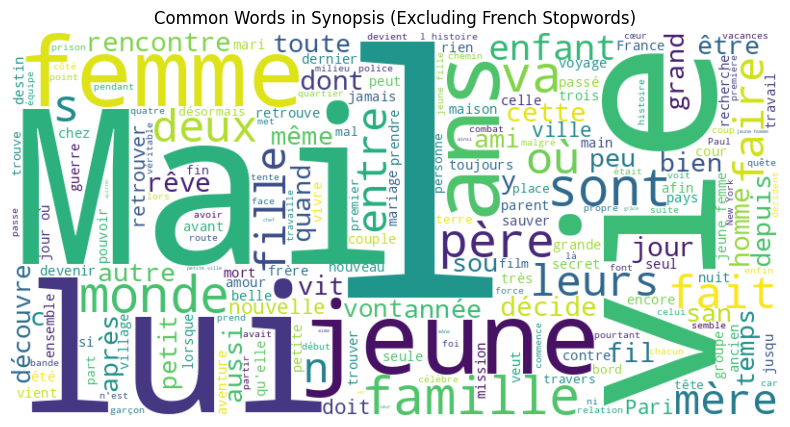

In [34]:
# --- 7. Text Analysis ---

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df):
    # Define French stopwords (you can expand this list if needed)
    french_stopwords = set([
        'd', 'alors', 'et', 'est', 'd\'une', 'd\'un', 'la', 'le', 'les', 'des', 'du', 'de', 'un', 'une', 'en', 'dans', 'que', 'qui', 
        'pour', 'sur', 'par', 'au', 'aux', 'ce', 'ces', 'son', 'sa', 'ses', 'ne', 'pas', 'ou', '1', 'qu', 'qu\'il', 'ont', 'c\'est',
        'plus', 'avec', 'il', 'elle', 'ils', 'leur', 'tout', 'tous', 'elles', 'nous', 'vous', 'se', 'comme', 'a', 'à', 'n\'a',
    ])

    # Combine with default stopwords
    custom_stopwords = STOPWORDS.union(french_stopwords)

    text = ' '.join(df['synopsis'].dropna().astype(str).tolist())
    print(text)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Common Words in Synopsis (Excluding French Stopwords)")
    plt.show()



generate_wordcloud(df_fusion)

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_57964/119896732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


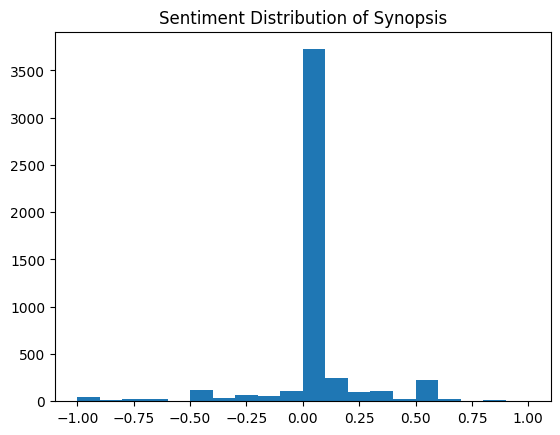

In [35]:
def sentiment_synopsis(df):
    df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plt.hist(df['synopsis_sentiment'], bins=20)
    plt.title("Sentiment Distribution of Synopsis")
    plt.show()

sentiment_synopsis(df_fusion)

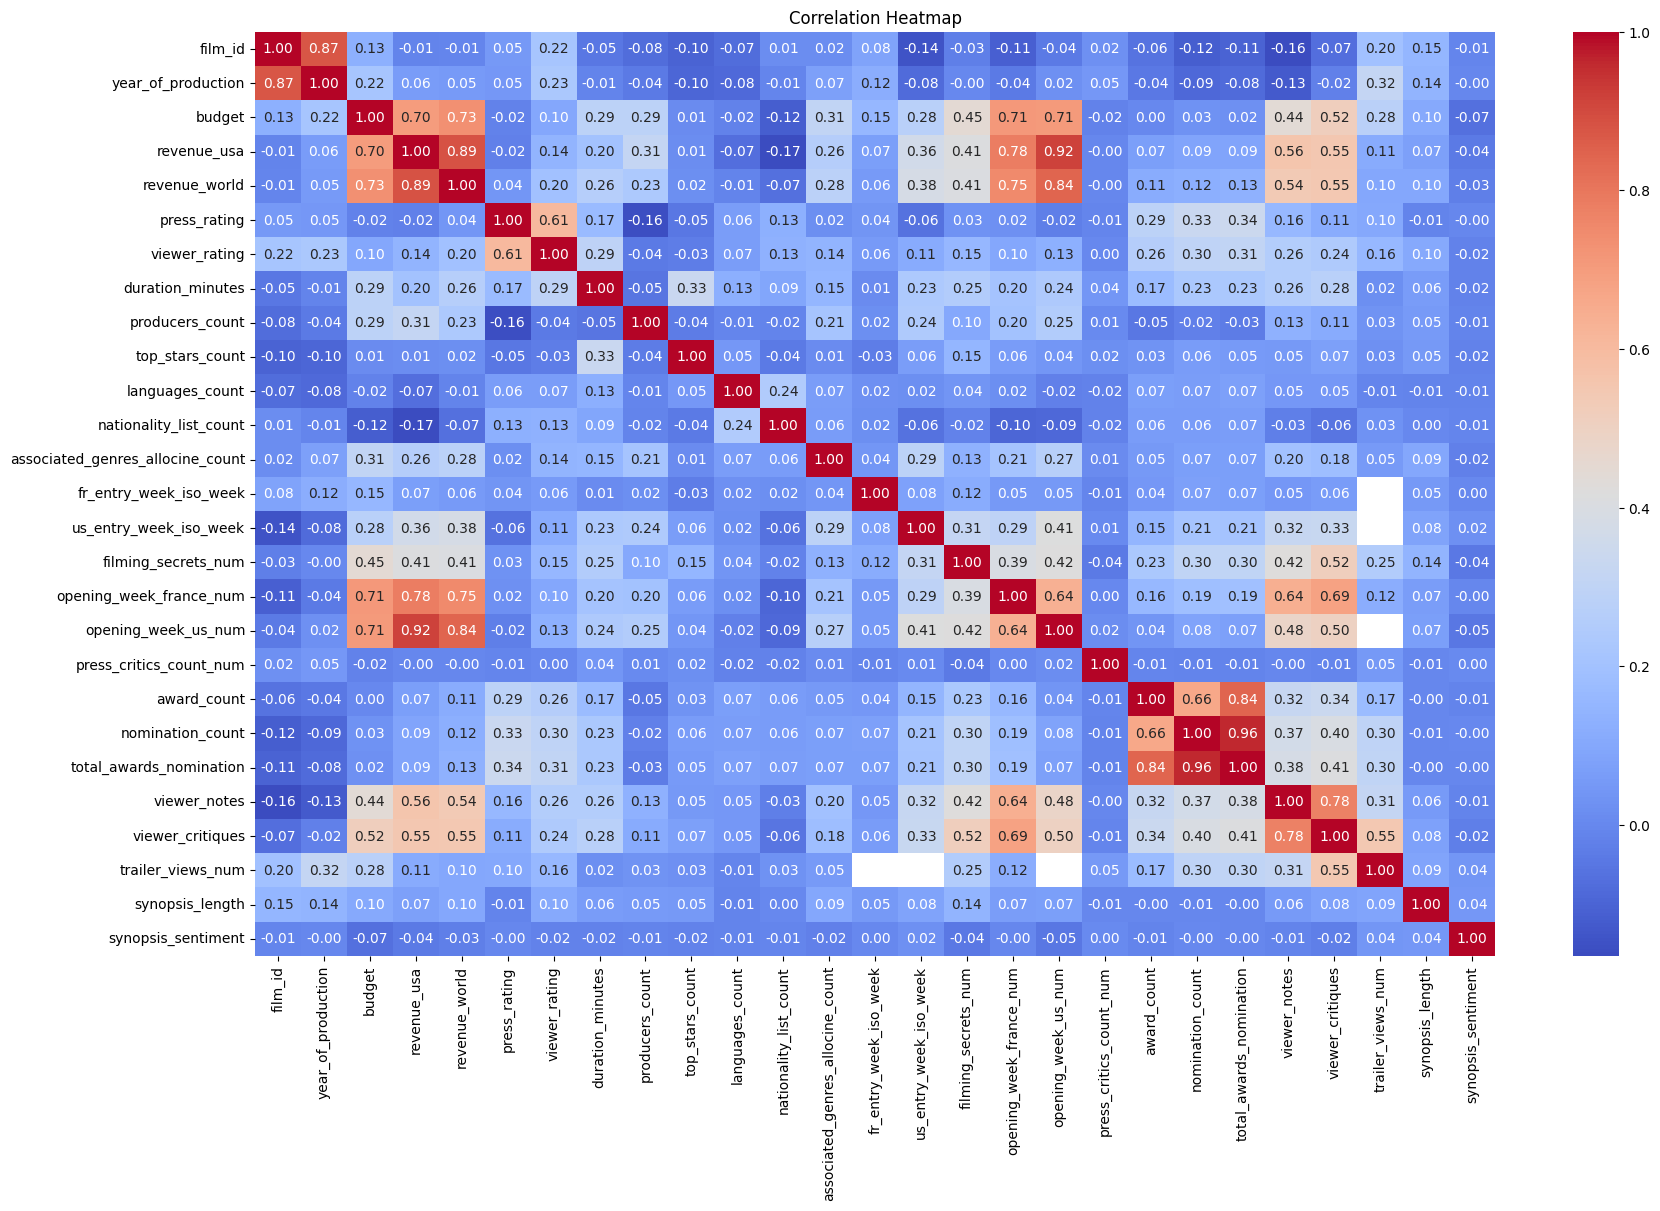

In [39]:
# --- 6. Correlation ---

def correlation_matrix(df):
    numeric_cols = df.select_dtypes(include=np.number)
    corr = numeric_cols.corr()
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

correlation_matrix(df_fusion)

In [ ]:


# # --- 4. Predictive Modeling ---
# def predict_revenue(df):
#     df_model = df[['budget', 'duration_minutes', 'viewer_rating']].dropna()
#     X = df_model.drop('viewer_rating', axis=1)
#     y = df_model['viewer_rating']
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)

#     print("MSE:", mean_squared_error(y_test, preds))
#     print("R2 Score:", r2_score(y_test, preds))

# --- 5. Clustering Movies ---
def cluster_movies(df):
    df_clust = df[['budget', 'duration_minutes', 'viewer_rating']].dropna()
    km = KMeans(n_clusters=4, random_state=42)
    df_clust['cluster'] = km.fit_predict(df_clust)
    sns.pairplot(df_clust, hue='cluster')
    plt.show()


# --- Example Business Questions Answered ---
# 1. What genres generate the most revenue or ratings?
# --> genre_performance(df)

# 2. Which actors consistently appear in top-grossing films?
# --> actor_success(df)

# 3. Does budget correlate with success?
# --> correlation_matrix(df)

# 4. How have movie trends (budget/duration/ratings) evolved?
# --> trend_budget_revenue(df)

# 5. Can we predict audience ratings based on duration and budget?
# --> predict_revenue(df)

# 6. What makes a movie likely to win awards?
# --> awards_vs_ratings(df)
